# Running models individually for each house

In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance
import time
import xgboost as xgb
from scripts.function_utils import last_energy_points, show_graphic_per_timestep, build_predict_show, total_averaged_metrics_individual

In [2]:
df = pd.read_csv("../../data/loureiro_40casas.csv")
number_of_houses = df.shape[1] - 1
df.Time = pd.to_datetime(df.Time)
df

,Time,Energy_1,Energy_2,Energy_9,Energy_15,Energy_16,Energy_17,Energy_30,Energy_35,Energy_48,...,Energy_138,Energy_139,Energy_142,Energy_146,Energy_148,Energy_151,Energy_159,Energy_160,Energy_161,Energy_164
0,2022-05-05 12:00:00,0.068,0.018,0.024,0.164,0.072,0.055,0.006,0.080,0.062,...,0.052,0.083,0.084,0.068,0.060,0.042,0.055,0.069,0.010,0.004
1,2022-05-05 12:15:00,0.070,0.018,0.024,0.135,0.058,0.060,0.006,0.056,0.062,...,0.052,0.053,0.004,0.048,0.078,0.053,0.055,0.063,0.010,0.003
2,2022-05-05 12:30:00,0.122,0.018,0.024,0.121,0.011,0.096,0.006,0.052,0.062,...,0.052,0.035,0.004,0.062,0.061,0.057,0.055,0.049,0.010,0.004
3,2022-05-05 12:45:00,0.132,0.018,0.024,0.138,0.010,0.064,0.006,0.052,0.062,...,0.052,0.082,0.004,0.056,0.125,0.034,0.055,0.097,0.010,0.004
4,2022-05-05 13:00:00,0.125,0.018,0.024,0.104,0.011,0.072,0.006,0.053,0.062,...,0.052,0.076,0.004,0.034,0.070,0.038,0.055,0.075,0.010,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38014,2023-06-07 01:15:00,0.120,0.020,0.066,0.120,0.003,0.094,0.037,0.045,0.071,...,0.047,0.054,0.004,0.080,0.014,0.028,0.066,0.058,0.000,0.003
38015,2023-06-07 01:30:00,0.121,0.004,0.057,0.087,0.002,0.077,0.036,0.046,0.059,...,0.051,0.038,0.004,0.060,0.028,0.023,0.067,0.032,0.016,0.004
38016,2023-06-07 01:45:00,0.158,0.007,0.056,0.086,0.003,0.087,0.021,0.045,0.059,...,0.068,0.045,0.004,0.057,0.029,0.043,0.065,0.495,0.008,0.003
38017,2023-06-07 02:00:00,0.102,0.042,0.056,0.085,0.002,0.072,0.027,0.045,0.059,...,0.067,0.053,0.003,0.061,0.012,0.047,0.041,0.274,0.000,0.004


## Preprocessing

In [3]:
X,y = last_energy_points(df.Energy_1, 97)
print(X.shape, y.shape)
X

(37922, 97) (37922, 1)


,lag_15,lag_30,lag_45,lag_60,lag_75,lag_90,lag_105,lag_120,lag_135,lag_150,...,lag_1320,lag_1335,lag_1350,lag_1365,lag_1380,lag_1395,lag_1410,lag_1425,lag_1440,lag_1455
0,0.099,0.225,0.194,0.182,0.148,0.078,0.076,0.080,0.087,0.055,...,0.156,0.091,0.111,0.112,0.089,0.125,0.132,0.122,0.070,0.068
1,0.083,0.099,0.225,0.194,0.182,0.148,0.078,0.076,0.080,0.087,...,0.377,0.156,0.091,0.111,0.112,0.089,0.125,0.132,0.122,0.070
2,0.067,0.083,0.099,0.225,0.194,0.182,0.148,0.078,0.076,0.080,...,0.089,0.377,0.156,0.091,0.111,0.112,0.089,0.125,0.132,0.122
3,0.093,0.067,0.083,0.099,0.225,0.194,0.182,0.148,0.078,0.076,...,0.096,0.089,0.377,0.156,0.091,0.111,0.112,0.089,0.125,0.132
4,0.127,0.093,0.067,0.083,0.099,0.225,0.194,0.182,0.148,0.078,...,0.093,0.096,0.089,0.377,0.156,0.091,0.111,0.112,0.089,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37917,0.103,0.102,0.183,0.290,0.444,0.096,0.016,0.028,0.029,0.049,...,0.074,0.114,0.123,0.055,0.072,0.024,0.019,0.033,0.040,0.041
37918,0.120,0.103,0.102,0.183,0.290,0.444,0.096,0.016,0.028,0.029,...,0.067,0.074,0.114,0.123,0.055,0.072,0.024,0.019,0.033,0.040
37919,0.121,0.120,0.103,0.102,0.183,0.290,0.444,0.096,0.016,0.028,...,0.057,0.067,0.074,0.114,0.123,0.055,0.072,0.024,0.019,0.033
37920,0.158,0.121,0.120,0.103,0.102,0.183,0.290,0.444,0.096,0.016,...,0.057,0.057,0.067,0.074,0.114,0.123,0.055,0.072,0.024,0.019


## Test model

In [4]:
start_timestep = 97
number_timesteps = 97

## XGBoost

In [5]:
model_xgb, preds_xgb, metrics_list_xgb = [],[],[]
start_t = time.time()
df_usable = df.drop("Time", axis=1)
for house in range(0,number_of_houses):
    print("\n House {}".format(house))
    mo_xgb, p_xgb, ml_xgb = build_predict_show(df_usable.iloc[:, house], number_timesteps, xgb.XGBRegressor(tree_method='gpu_hist', seed=0, colsample_bytree=0.7, learning_rate=0.1, max_depth=20, n_estimators=1000), start_timestep=start_timestep)
    model_xgb.append(mo_xgb)
    preds_xgb.append(p_xgb)
    metrics_list_xgb.append(ml_xgb)
print("\nXGBoost Elapsed time: %.3f seconds" % (time.time() - start_t))


 House 0

Number of features  97
MSE: 0.0054
RMSE: 0.0735
WAPE: 41.31
R2: 0.5196

Elapsed time: 10.949 seconds

Full Elapsed time: 10.949 seconds

 House 1

Number of features  97
MSE: 0.0032
RMSE: 0.0573
WAPE: 56.59
R2: 0.2070

Elapsed time: 10.032 seconds

Full Elapsed time: 10.032 seconds

 House 2

Number of features  97
MSE: 0.0022
RMSE: 0.0478
WAPE: 26.11
R2: 0.7116

Elapsed time: 9.708 seconds

Full Elapsed time: 9.708 seconds

 House 3

Number of features  97
MSE: 0.0061
RMSE: 0.0786
WAPE: 36.43
R2: 0.4070

Elapsed time: 11.801 seconds

Full Elapsed time: 11.801 seconds

 House 4

Number of features  97
MSE: 0.0000
RMSE: 0.0064
WAPE: 8.93
R2: 0.9575

Elapsed time: 3.324 seconds

Full Elapsed time: 3.324 seconds

 House 5

Number of features  97
MSE: 0.0051
RMSE: 0.0716
WAPE: 35.35
R2: 0.5486

Elapsed time: 11.388 seconds

Full Elapsed time: 11.388 seconds

 House 6

Number of features  97
MSE: 0.0044
RMSE: 0.0666
WAPE: 56.25
R2: 0.3573

Elapsed time: 9.686 seconds

Full Elapse

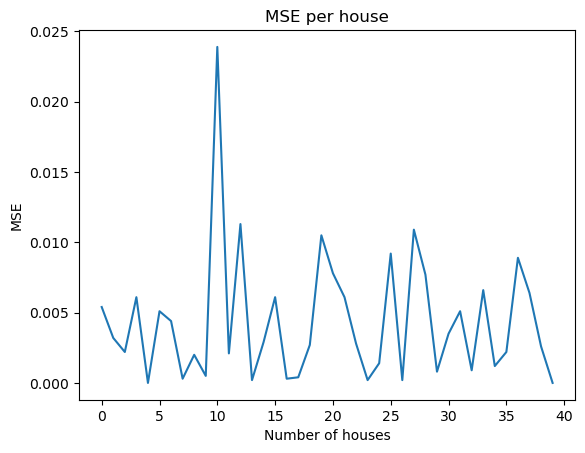

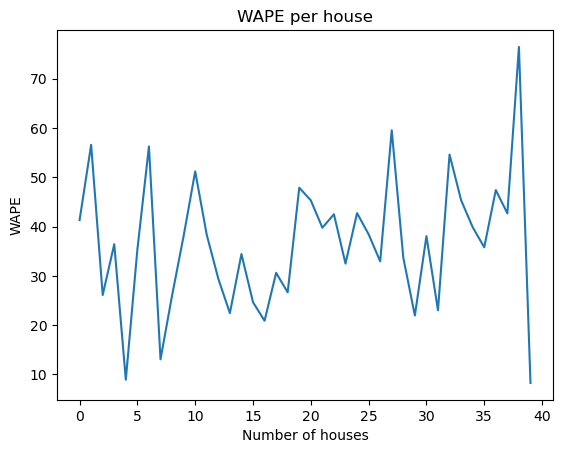

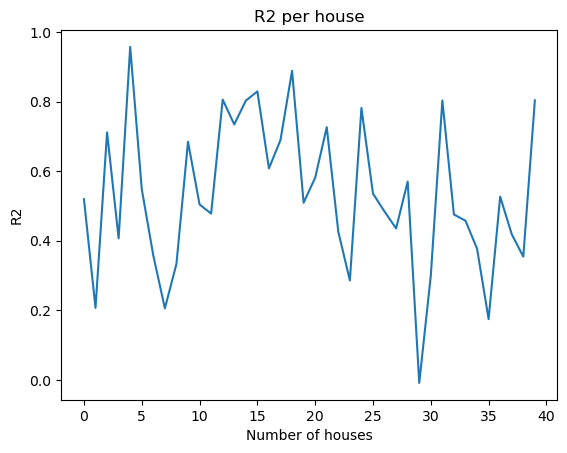

In [6]:
show_graphic_per_timestep(metrics_list_xgb, number_of_houses)

### Total average

In [7]:
t_mse,t_wape, t_r2 = total_averaged_metrics_individual(metrics_list_xgb)

Total Averaged MSE: 0.004
Total Averaged WAPE: 36.639
Total Averaged R2: 0.532


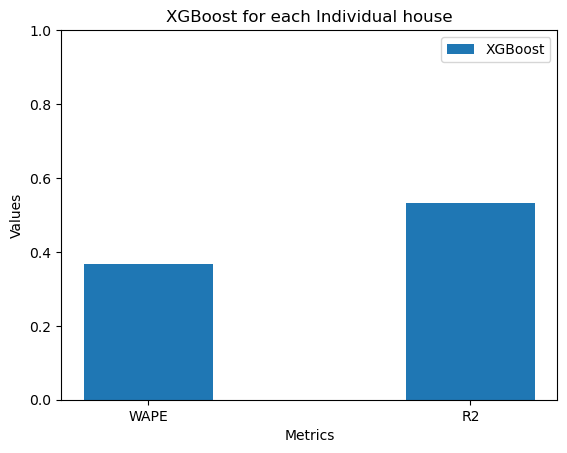

In [8]:
X_names = ("WAPE", "R2")
X_axis = np.arange(len(X_names))
plt.bar(X_axis, (t_wape / 100, t_r2), 0.4, label = 'XGBoost')
plt.ylim(0,1)
plt.xticks(X_axis, X_names)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("XGBoost for each Individual house")
plt.legend()
plt.show()